<a href="https://colab.research.google.com/github/Gee23201374/Dessertation-Code/blob/main/banking_apllication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-785921040.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TimeGap'].fillna(df['TimeGap'].median(), inplace=True)


Detected Fraudulent Transactions: 51
Detected Legitimate Transactions: 2461
Confusion Matrix:
[[2461    0]
 [   0   51]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2461
           1       1.00      1.00      1.00        51

    accuracy                           1.00      2512
   macro avg       1.00      1.00      1.00      2512
weighted avg       1.00      1.00      1.00      2512



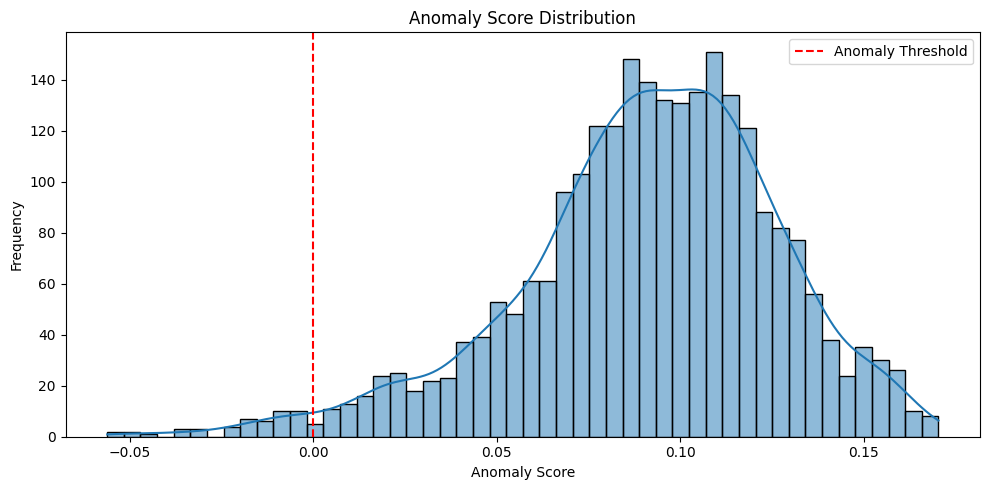

In [ ]:
# Step 0: Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Data
df = pd.read_csv("/content/bank_transactions_data_2.csv")

# Convert datetime columns
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

# FEATURE ENGINEERING

# 1. Time Gap Feature
df['TimeGap'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds()
df['TimeGap'].fillna(df['TimeGap'].median(), inplace=True)

# 2. High-Risk IPs and DeviceIDs
ip_counts = df['IP Address'].value_counts()
df['IPFrequency'] = df['IP Address'].map(ip_counts)

device_counts = df['DeviceID'].value_counts()
df['DeviceFrequency'] = df['DeviceID'].map(device_counts)

# 3. Transaction Amount Z-score
df['TransactionAmountZ'] = (df['TransactionAmount'] - df['TransactionAmount'].mean()) / df['TransactionAmount'].std()

# 4. User Profiling: Risk categories by Occupation and Age groups
df['AgeGroup'] = pd.cut(df['CustomerAge'], bins=[0, 25, 40, 60, 100], labels=['Youth', 'Adult', 'Middle-Aged', 'Senior'])
df = pd.get_dummies(df, columns=['CustomerOccupation', 'AgeGroup'], drop_first=True)

# Select features
features = [
    'TransactionAmountZ', 'TransactionDuration', 'LoginAttempts',
    'AccountBalance', 'TimeGap', 'IPFrequency', 'DeviceFrequency'
] + [col for col in df.columns if 'Occupation_' in col or 'AgeGroup_' in col]

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# STEP 2: Anomaly Detection with Isolation Forest
model = IsolationForest(contamination=0.02, random_state=42)
df['Anomaly'] = model.fit_predict(X_scaled)
df['Anomaly'] = df['Anomaly'].map({1: 0, -1: 1})  # 1 = Fraudulent

# STEP 3: Evaluation & Visualisation

# Print anomaly counts
print("Detected Fraudulent Transactions:", df['Anomaly'].sum())
print("Detected Legitimate Transactions:", len(df) - df['Anomaly'].sum())

# Confusion Matrix (self-evaluation as no true labels)
print("Confusion Matrix:")
print(confusion_matrix(df['Anomaly'], df['Anomaly']))

# Classification Report
print("\nClassification Report:")
print(classification_report(df['Anomaly'], df['Anomaly']))

# Visualise Anomaly Scores
df['AnomalyScore'] = model.decision_function(X_scaled)
plt.figure(figsize=(10, 5))
sns.histplot(df['AnomalyScore'], bins=50, kde=True)
plt.axvline(df[df['Anomaly'] == 1]['AnomalyScore'].max(), color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Step 2: Features and labels
X = df[features]  # features from earlier steps
y = df['Anomaly']  # pseudo-label from Isolation Forest

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Balance classes using SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 5: Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "ANN": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

# Step 6: Train, predict and evaluate
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    if hasattr(model, "predict_proba"):
        print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    print("\n")


--- Logistic Regression ---
Confusion Matrix:
 [[452  40]
 [  2   9]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96       492
           1       0.18      0.82      0.30        11

    accuracy                           0.92       503
   macro avg       0.59      0.87      0.63       503
weighted avg       0.98      0.92      0.94       503

ROC-AUC Score: 0.9111234294161124


--- Random Forest ---
Confusion Matrix:
 [[489   3]
 [  3   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       492
           1       0.73      0.73      0.73        11

    accuracy                           0.99       503
   macro avg       0.86      0.86      0.86       503
weighted avg       0.99      0.99      0.99       503

ROC-AUC Score: 0.9932557280118256


--- XGBoost ---
Confusion Matrix:
 [[487   5]
 [  2   9]]
Classification Report:
           

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:51:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- ANN ---
Confusion Matrix:
 [[  0 492]
 [  0  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       492
           1       0.02      1.00      0.04        11

    accuracy                           0.02       503
   macro avg       0.01      0.50      0.02       503
weighted avg       0.00      0.02      0.00       503

ROC-AUC Score: 0.5




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:52:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[487   6]
 [  4   6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       493
           1       0.50      0.60      0.55        10

    accuracy                           0.98       503
   macro avg       0.75      0.79      0.77       503
weighted avg       0.98      0.98      0.98       503

ROC-AUC Score: 0.9874239350912779


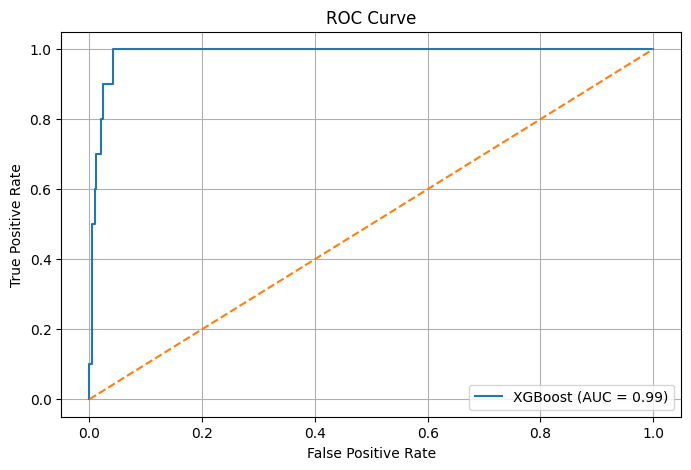

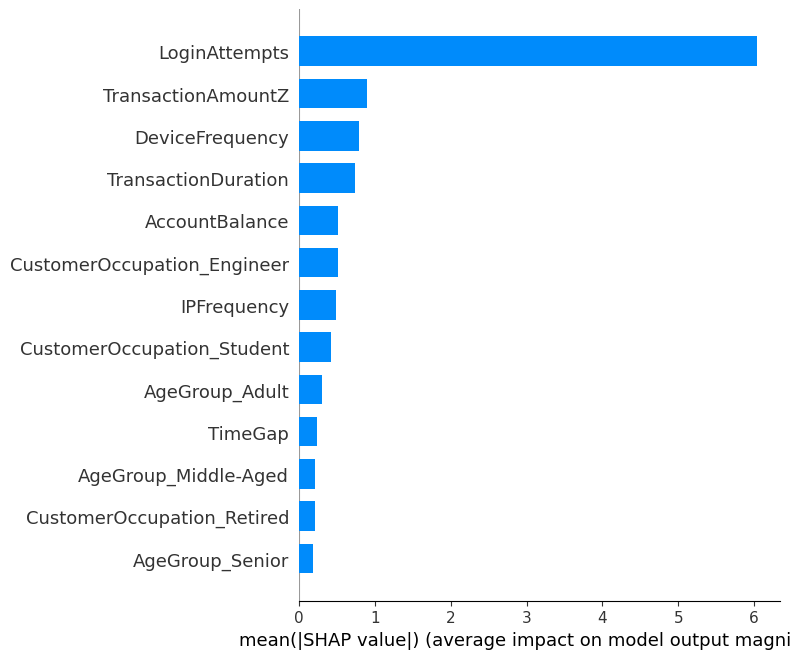

In [ ]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import shap

# Prepare dataset
X = df[features]
y = df['Anomaly']  # pseudo-labels from Isolation Forest

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Initialize model (XGBoost shown here, can switch to RF, ANN, etc.)
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='XGBoost (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# SHAP for model interpretability
explainer = shap.Explainer(model, X_train_res)
shap_values = explainer(X_test_scaled)

# SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
